# Linear Optimization

Optimizes a linear straight-line path from a point on the viable brain surface region to a point on the subthalamic nucleus (STN) for DBS electrode planning.

Treats the following as obstacles:
- Sulci
- Ventricles
- Corpus Callosum (prevent brain crossing)

**Objective Functions**
- Distance to obstacles
- Minimum path distance  *(not optimized yet)*

## 1. Setup

### Import Libraries

In [1]:
import os
import glob
import random
import numpy as np

import vedo
from vedo import Volume, show, Line, merge, Plotter

from scipy.optimize import minimize

import k3d

In [2]:
# Set vedo backend to pop out plots in separate windows
vedo.settings.default_backend = '2d' # or 'vt' or '2d' or 'k3d' or 'ipyvtklink'

### Configuration and Setup

In [3]:
# Define new base directory and sub-folder structure
base_dir = "./FINAL_BRAIN_ATLAS/final_nii_files"

# Entry zones (viable surface regions for path start)
entry_zone_dir = os.path.join(base_dir, "entry_zone")
left_entry_zone_dir = os.path.join(entry_zone_dir, "LEFT_ENTRY_ZONE")
right_entry_zone_dir = os.path.join(entry_zone_dir, "RIGHT_ENTRY_ZONE")

# Subthalamic nucleus (targets)
stn_root_dir = os.path.join(base_dir, "subthalamic_nucleus")
left_stn_dir = os.path.join(stn_root_dir, "LEFT_STN")
right_stn_dir = os.path.join(stn_root_dir, "RIGHT_STN")

# Full brain (for context / outline only)
full_brain_dir = os.path.join(base_dir, "full_brain")

# Skin surface (outer head/skin/skull)
skin_dir = os.path.join(base_dir, "skin")

# Obstacles (same role as before)
obstacles_dir = os.path.join(base_dir, "obstacles")

print("Base directory:", base_dir)


Base directory: ./FINAL_BRAIN_ATLAS/final_nii_files


### Load Brain Structures

Recursively load all `.nii` / `.nii.gz` files under each designated root:
- Entry Zones (LEFT/RIGHT) viable start regions (light brown, low alpha)
- STN Targets (LEFT/RIGHT) (distinct greens)
- Obstacles (red)
- Full Brain outline (very light grey, minimal alpha)

All subfolder contents are merged later per category.

In [4]:
# Initialize lists for different structure types
left_entry_zone_structures = []
right_entry_zone_structures = []
left_stn_structures = []
right_stn_structures = []
allowed_left_entry_zone_structures = []
allowed_right_entry_zone_structures = []
obstacle_structures = []
full_brain_structures = []
skin_structures = []

# Loader utility: walk all subfolders and load every .nii / .nii.gz
def load_folder_surfaces(root_folder, color, alpha=1.0):
    loaded = []
    if not os.path.isdir(root_folder):
        print(f"[WARN] Folder not found: {root_folder}")
        return loaded
    
    for dirpath, dirnames, filenames in os.walk(root_folder):
        nii_files = [f for f in filenames if f.lower().endswith('.nii') or f.lower().endswith('.nii.gz')]
        for fname in nii_files:
            fpath = os.path.join(dirpath, fname)
            rel = os.path.relpath(fpath, root_folder)
            print(f"  Loading structure: {rel}")
            try:
                vol = Volume(fpath)
                surf = vol.isosurface()
                surf.c(color).alpha(alpha)
                loaded.append(surf)
            except Exception as e:
                print(f"  [WARN] Failed to load volume/surface: {fpath} ({e})")
    if not loaded:
        print(f"  [INFO] No NIfTI files found under {root_folder}")
    return loaded

print("\nLoading Entry Zones (LEFT)...")
left_entry_zone_structures = load_folder_surfaces(left_entry_zone_dir, color=(0.95, 0.65, 0.85), alpha=0.04)
print("Loading Entry Zones (RIGHT)...")
right_entry_zone_structures = load_folder_surfaces(right_entry_zone_dir, color=(0.95, 0.75, 0.85), alpha=0.04)

# STN folders (may already be deepest; recursion still safe)
print("\nLoading STN (LEFT)...")
left_stn_structures = load_folder_surfaces(left_stn_dir, color="green", alpha=1.0)
print("Loading STN (RIGHT)...")
right_stn_structures = load_folder_surfaces(right_stn_dir, color="green", alpha=1.0)

print("\nLoading Obstacles...")
obstacle_structures = load_folder_surfaces(obstacles_dir, color="red", alpha=0.7)

print("\nLoading Full Brain Outline...")
full_brain_structures = load_folder_surfaces(full_brain_dir, color="grey", alpha=0.01)

print("\nLoading Skin Surface...")
# Use light skin tone color and slightly higher alpha for visibility
skin_structures = load_folder_surfaces(skin_dir, color="grey", alpha=0.02)



Loading Entry Zones (LEFT)...
  Loading structure: LEFT_FRONTAL_LOBE/Model_1017_left_paracentral_lobule.nii
  Loading structure: LEFT_FRONTAL_LOBE/Model_1028_left_superior_frontal_gyrus.nii
  Loading structure: LEFT_FRONTAL_LOBE/Model_1027_anterior_part_of_left_middle_frontal_gyrus.nii
  Loading structure: LEFT_FRONTAL_LOBE/Model_1020_triangular_part_of_left_inferior_frontal_gyrus.nii
  Loading structure: LEFT_FRONTAL_LOBE/Model_1003_posterior_part_of_left_middle_frontal_gyrus.nii
  Loading structure: LEFT_FRONTAL_LOBE/Model_1024_left_precentral_gyrus.nii
  Loading structure: LEFT_FRONTAL_LOBE/Model_1018_opercular_part_of_left_inferior_frontal_gyrus.nii
  Loading structure: LEFT_FRONTAL_LOBE/Model_1012_left_lateral_orbital_gyrus.nii
  Loading structure: LEFT_FRONTAL_LOBE/Model_1032_left_frontal_pole.nii
  Loading structure: LEFT_FRONTAL_LOBE/Model_1014_left_straight_gyrus.nii
  Loading structure: LEFT_FRONTAL_LOBE/Model_1019_orbital_part_of_left_inferior_frontal_gyrus.nii
  Loading st

### Merge Structures

Combine individual structures into single meshes for:
- LEFT/RIGHT Entry Zones (start sampling)
- LEFT/RIGHT STN (target sampling hemisphere-consistent)
- Obstacles (for intersection & distance)
- Full Brain (context outline only)


In [5]:
# Merge structures into single meshes
merged_left_entry_zone = merge(left_entry_zone_structures) if left_entry_zone_structures else None
if merged_left_entry_zone: merged_left_entry_zone.alpha(0.04)

merged_right_entry_zone = merge(right_entry_zone_structures) if right_entry_zone_structures else None
if merged_right_entry_zone: merged_right_entry_zone.alpha(0.04)

merged_allowed_left_entry_zone = merged_left_entry_zone
merged_allowed_right_entry_zone = merged_right_entry_zone

merged_left_stn = merge(left_stn_structures) if left_stn_structures else None
merged_right_stn = merge(right_stn_structures) if right_stn_structures else None

merged_obstacles = merge(obstacle_structures) if obstacle_structures else None
if merged_obstacles: merged_obstacles.c("red").alpha(0.75)

merged_full_brain = merge(full_brain_structures) if full_brain_structures else None
if merged_full_brain: merged_full_brain.c("grey").alpha(0.01)

merged_skin = merge(skin_structures) if skin_structures else None
if merged_skin: merged_skin.c("grey").alpha(0.02)

print("\nMerged Summary:")
print(f"  Left Entry Zone: {'yes' if merged_left_entry_zone else 'no'}")
print(f"  Right Entry Zone: {'yes' if merged_right_entry_zone else 'no'}")
print(f"  Left Allowed Entry Zone: {'yes' if merged_allowed_left_entry_zone else 'no'}")
print(f"  Right Allowed Entry Zone: {'yes' if merged_allowed_right_entry_zone else 'no'}")
print(f"  Left STN: {'yes' if merged_left_stn else 'no'}")
print(f"  Right STN: {'yes' if merged_right_stn else 'no'}")
print(f"  Obstacles: {'yes' if merged_obstacles else 'no'}")
print(f"  Full Brain: {'yes' if merged_full_brain else 'no'}")
print(f"  Skin: {'yes' if merged_skin else 'no'}")



Merged Summary:
  Left Entry Zone: yes
  Right Entry Zone: yes
  Left Allowed Entry Zone: yes
  Right Allowed Entry Zone: yes
  Left STN: yes
  Right STN: yes
  Obstacles: yes
  Full Brain: yes
  Skin: no


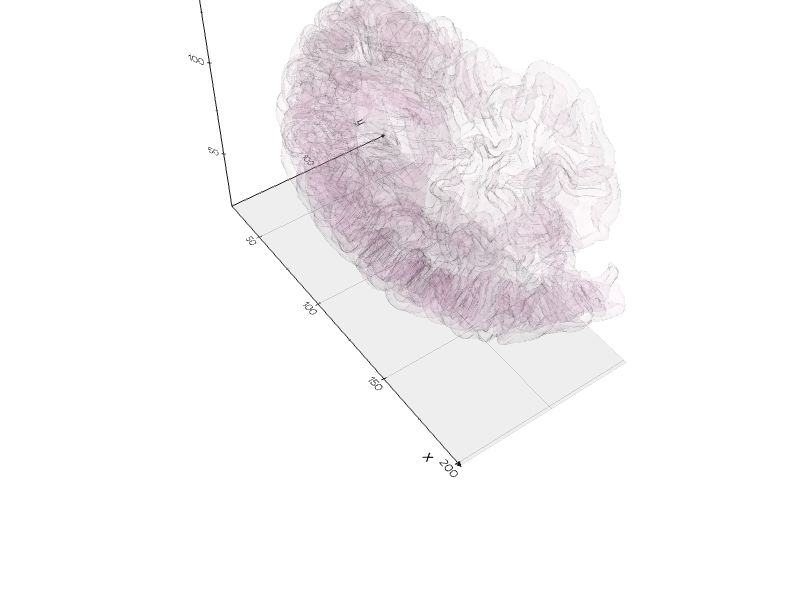

In [6]:
# Plot and show the outer entry zone
actors1 = []
actors1.append(merged_allowed_left_entry_zone)
actors1.append(merged_allowed_right_entry_zone)
actors1.append(merged_skin)
# actors1.append(merged_full_brain)
show(actors1, axes=1, viewup="z", title="Entry Zones")


### Helper Functions

In [7]:
def compute_path_length(start_point, end_point):
    """Compute the distance between two points for the line path."""
    return np.linalg.norm(np.array(end_point) - np.array(start_point))


def compute_obstacle_distance(start_point, end_point):
    """Compute the minimum distance from the line path to any obstacle."""
    if merged_obstacles is None:
        return 0.0
    temp_line = Line([start_point, end_point])
    d = temp_line.distance_to(merged_obstacles)
    if isinstance(d, (list, tuple, np.ndarray)):
        return float(np.min(d))
    return float(d)


def check_intersection(start_point, end_point):
    """Check if the line path intersects any obstacle."""
    if merged_obstacles is None:
        return False
    intersections = merged_obstacles.intersect_with_line(start_point, end_point)
    return intersections is not None and len(intersections) > 0


def _closest_point_on_mesh(point, mesh):
    """Project a 3D point onto the closest point on a mesh surface."""
    if mesh is None:
        return tuple(point)
    try:
        cp = mesh.closest_point(point)
        return tuple(cp)
    except Exception:
        # Fallback to nearest vertex
        verts = np.asarray(mesh.vertices)
        if verts.size == 0:
            return tuple(point)
        idx = int(np.argmin(np.linalg.norm(verts - np.asarray(point), axis=1)))
        return tuple(verts[idx])


def project_to_surfaces(start_point, end_point, hemisphere):
    """Project start onto entry zone then onto skin; end onto STN for hemisphere."""
    # 1. project to entry zone of hemisphere
    if hemisphere == 'left':
        sp_entry = _closest_point_on_mesh(start_point, merged_allowed_left_entry_zone)
        ep = _closest_point_on_mesh(end_point, merged_left_stn)
    else:
        sp_entry = _closest_point_on_mesh(start_point, merged_allowed_right_entry_zone)
        ep = _closest_point_on_mesh(end_point, merged_right_stn)
    # 2. project onto head skin surface
    sp = _closest_point_on_mesh(sp_entry, merged_skin)
    return sp, ep


def sample_start_and_end():
    """Sample a hemisphere-consistent start (entry zone) and end (STN)."""
    hemispheres = []
    if merged_allowed_left_entry_zone and merged_left_stn:
        hemispheres.append('left')
    if merged_allowed_right_entry_zone and merged_right_stn:
        hemispheres.append('right')
    if not hemispheres:
        raise RuntimeError("No valid hemisphere data available for sampling.")
    hemi = random.choice(hemispheres)
    # Sample a random point from entry zone surface, then project to skin
    if hemi == 'left':
        start_entry = tuple(merged_allowed_left_entry_zone.generate_random_points(1).points[0])
        end = tuple(merged_left_stn.generate_random_points(1).points[0])
    else:
        start_entry = tuple(merged_allowed_right_entry_zone.generate_random_points(1).points[0])
        end = tuple(merged_right_stn.generate_random_points(1).points[0])
    start = _closest_point_on_mesh(start_entry, merged_skin)
    return hemi, start, end


## 2. Monte Carlo Optimization

### Path Generation and Optimization

Generate random paths from brain surface to STN and evaluate them:
- **Orange lines**: Failed paths (intersect obstacles)
- **Yellow lines**: Successful but suboptimal paths
- **Green line**: Optimal path (maximum distance from obstacles)

**Optimization Algorithm**

Runs until finding a minimum of `min_successful_attempts`, or up until `max_attempts`.

Chooses a **random location** from the viable brain surface region and the STN of the corresponding hemisphere. 

For each plot, the distance from obstacles is saved. The "best" path is determined using the highest distance to obstacles.

In [8]:
## Config for Monte Carlo
# Monte Carlo path generation parameters
max_attempts = 2000
min_successful_attempts = 100

# Line width configuration (for visualization)
BEST_PATH_WIDTH = 6
SUBOPTIMAL_PATH_WIDTH = 4
FAILED_PATH_WIDTH = 4

In [9]:
## Run Monte Carlo sampling

successful_attempts = []  # Store (hemisphere, start_point, end_point, obstacle_distance, path_length) tuples
failed_attempts = []      # Store (hemisphere, start_point, end_point, obstacle_distance(=0 for fail), path_length)
failed_lines = []

for attempt in range(max_attempts):
    if len(successful_attempts) >= min_successful_attempts:
        break

    hemi, start_point, end_point = sample_start_and_end()
    print(f"Attempt {attempt+1}: hemisphere={hemi} start={start_point} end={end_point}")

    path_len = compute_path_length(start_point, end_point)

    # Check for intersection if we have obstacles
    if merged_obstacles:
        if not check_intersection(start_point, end_point):
            # Compute metrics
            temp_line = Line([start_point, end_point])
            obstacle_dist = compute_obstacle_distance(start_point, end_point)
            successful_attempts.append((hemi, start_point, end_point, obstacle_dist, path_len))
            print(f"  SUCCESS ({len(successful_attempts)}/{min_successful_attempts}) - Obstacle Distance: {obstacle_dist:.3f} Path Length: {path_len:.3f}")
        else:
            failed_line = Line([start_point, end_point]).c("orange").alpha(0.3).lw(FAILED_PATH_WIDTH)
            failed_lines.append(failed_line)
            failed_attempts.append((hemi, start_point, end_point, 0.0, path_len))
            print("  FAIL - Line intersects obstacles")
    else:
        obstacle_dist = 0.0
        successful_attempts.append((hemi, start_point, end_point, obstacle_dist, path_len))
        print(f"  SUCCESS ({len(successful_attempts)}/{min_successful_attempts}) (no obstacles) Path Length: {path_len:.3f}")
else:
    print(f"Warning: Only found {len(successful_attempts)} non-intersecting lines after {max_attempts} attempts")

Attempt 1: hemisphere=right start=(np.float32(119.776146), np.float32(115.400276), np.float32(120.37414)) end=(np.float32(107.371895), np.float32(130.0), np.float32(82.64597))
  SUCCESS (1/100) - Obstacle Distance: 3.820 Path Length: 42.313
Attempt 2: hemisphere=right start=(np.float32(134.66942), np.float32(96.5), np.float32(124.51507)) end=(np.float32(107.60859), np.float32(132.04805), np.float32(84.81054))
  SUCCESS (2/100) - Obstacle Distance: 6.304 Path Length: 59.770
Attempt 3: hemisphere=left start=(np.float32(167.54663), np.float32(92.75), np.float32(67.989044)) end=(np.float32(107.13286), np.float32(129.25), np.float32(72.7106))
  FAIL - Line intersects obstacles
Attempt 4: hemisphere=left start=(np.float32(159.54204), np.float32(90.55557), np.float32(76.4024)) end=(np.float32(107.40506), np.float32(132.65506), np.float32(72.91455))
  SUCCESS (3/100) - Obstacle Distance: 3.942 Path Length: 67.103
Attempt 5: hemisphere=left start=(np.float32(113.05254), np.float32(95.17965), np

### Select Optimal Path

Find the best path among successful attempts by maximizing distance from obstacles.

In [10]:
# Select best path (maximum obstacle distance; tie-breaker shorter path length)
SUBOPTIMAL_PATHS_TO_DISPLAY = 10

best_path = None
suboptimal_lines = []
selected_hemisphere = None

if successful_attempts:
    # Sort: first by obstacle distance desc, then by path length asc
    successful_attempts.sort(key=lambda x: (-x[3], x[4]))

    best_hemi, best_start, best_end, best_obstacle_dist, best_path_len = successful_attempts[0]
    best_path = Line([best_start, best_end]).c("green").lw(BEST_PATH_WIDTH)
    selected_hemisphere = best_hemi
    print(f"\nBest path: hemisphere={best_hemi} obstacle_dist={best_obstacle_dist:.3f} path_len={best_path_len:.3f}")

    s = 1
    for hemi, start_pt, end_pt, obstacle_dist, path_len in successful_attempts[1:]:
        if s > SUBOPTIMAL_PATHS_TO_DISPLAY:
            break
        
        suboptimal_line = Line([start_pt, end_pt]).c("yellow").alpha(0.3).lw(SUBOPTIMAL_PATH_WIDTH)
        suboptimal_lines.append(suboptimal_line)
        print(f"Suboptimal path {s}: hemi={hemi} obstacle_dist={obstacle_dist:.3f} path_len={path_len:.3f}")
        
        s += 1
else:
    print("No successful paths found!")

print("\nTotal successful paths: ", len(successful_attempts))


Best path: hemisphere=right obstacle_dist=7.318 path_len=70.072
Suboptimal path 1: hemi=right obstacle_dist=7.207 path_len=75.271
Suboptimal path 2: hemi=right obstacle_dist=6.958 path_len=64.013
Suboptimal path 3: hemi=right obstacle_dist=6.749 path_len=49.543
Suboptimal path 4: hemi=right obstacle_dist=6.728 path_len=56.637
Suboptimal path 5: hemi=right obstacle_dist=6.625 path_len=70.905
Suboptimal path 6: hemi=right obstacle_dist=6.605 path_len=62.209
Suboptimal path 7: hemi=right obstacle_dist=6.553 path_len=56.546
Suboptimal path 8: hemi=right obstacle_dist=6.452 path_len=76.851
Suboptimal path 9: hemi=right obstacle_dist=6.379 path_len=53.087
Suboptimal path 10: hemi=right obstacle_dist=6.304 path_len=59.770

Total successful paths:  100


In [11]:
## Save Monte Carlo path coordinates to file (success + fail + best flag)
output_file = "monte_carlo_paths.csv"
with open(output_file, 'w') as f:
    f.write("hemisphere,start_x,start_y,start_z,end_x,end_y,end_z,obstacle_distance,path_length,status,is_best\n")
    # Successful attempts are already sorted (best first) after selection step
    for idx, (hemi, start_pt, end_pt, obstacle_dist, path_len) in enumerate(successful_attempts):
        is_best = 1 if idx == 0 else 0
        f.write(
            f"{hemi},{start_pt[0]},{start_pt[1]},{start_pt[2]},{end_pt[0]},{end_pt[1]},{end_pt[2]},{obstacle_dist},{path_len},success,{is_best}\n"
        )
    # Failed attempts
    for hemi, start_pt, end_pt, obstacle_dist, path_len in failed_attempts:
        f.write(
            f"{hemi},{start_pt[0]},{start_pt[1]},{start_pt[2]},{end_pt[0]},{end_pt[1]},{end_pt[2]},{obstacle_dist},{path_len},fail,0\n"
        )
print(f"Saved Monte Carlo paths ({len(successful_attempts)} success, {len(failed_attempts)} fail) to {output_file}")

Saved Monte Carlo paths (100 success, 73 fail) to monte_carlo_paths.csv


# Pareto Front

In [ ]:
import time

output_file = "optimal_path_comparison.csv"
with open(output_file, 'w') as f:
    f.write("method,weights,hemisphere,start_x,start_y,start_z,end_x,end_y,end_z,obstacle_distance,path_length,weighted_objective\n")

def weighted_sum_objective(x):
    """
    Weighted sum objective function for optimization.

    Parameters:
    -----------
    x : array-like, shape (6,)
        [start_x, start_y, start_z, end_x, end_y, end_z]

    Returns:
    --------
    float : Objective value (to be minimized)
    """
    global nm_hemisphere
    start_guess = tuple(x[:3])
    end_guess = tuple(x[3:])

    # If hemisphere not set, infer a reasonable default
    if nm_hemisphere is None:
        nm_hemisphere = 'left' if merged_left_entry_zone and merged_left_stn else 'right'

    # Project guesses to valid surfaces for the locked hemisphere
    start_point, end_point = project_to_surfaces(start_guess, end_guess, nm_hemisphere)

    # Hard constraint: penalize intersection
    if check_intersection(start_point, end_point):
        return 1e10

    # Compute objectives
    obstacle_dist = compute_obstacle_distance(start_point, end_point)
    path_length = compute_path_length(start_point, end_point)

    # Normalize objectives
    if max_obstacle_dist is not None and max_obstacle_dist > 0:
        norm_obstacle_dist = obstacle_dist / max_obstacle_dist
    else:
        norm_obstacle_dist = obstacle_dist / 8

    if max_path_length is not None and max_path_length > 0:
        norm_path_length = path_length / max_path_length
    else:
        norm_path_length = path_length / 105

    # Weighted sum: minimize (-obstacle_dist) and minimize path_length
    objective = -w_obstacle_norm * norm_obstacle_dist + w_path_length_norm * norm_path_length
    return objective

def run_multistart(method_name, options):
    """Run chosen optimization method over all initial_paths and return best record.

    Returns:
      best_record, records_list
    Prints per-start info plus total elapsed time and summed iterations across starts.
    """
    if not initial_paths:
        raise RuntimeError("initial_paths is empty. Ensure Monte Carlo step ran and initial paths were selected.")

    best = None
    records = []
    total_time = 0.0
    total_iterations = 0

    for idx, (hemi, start, end, obst, plen) in enumerate(initial_paths, start=1):
        print(f"\n[{method_name} {idx}/{len(initial_paths)}] hemi={hemi}")
        global nm_hemisphere
        nm_hemisphere = hemi  # hemisphere locking
        x0 = np.concatenate([start, end])
        t0 = time.perf_counter()
        res = minimize(weighted_sum_objective, x0, method=method_name, options=options)
        elapsed = time.perf_counter() - t0
        iters = getattr(res, 'nit', getattr(res, 'nfev', 0)) or 0
        total_time += elapsed
        total_iterations += iters

        raw_start = tuple(res.x[:3])
        raw_end = tuple(res.x[3:])
        opt_start, opt_end = project_to_surfaces(raw_start, raw_end, nm_hemisphere)
        opt_obj = float(res.fun)
        opt_obst = compute_obstacle_distance(opt_start, opt_end)
        opt_len = compute_path_length(opt_start, opt_end)
        opt_line = Line([opt_start, opt_end]).c("cyan").lw(10) if method_name == 'Nelder-Mead' else Line([opt_start, opt_end]).c("magenta" if method_name=='Powell' else "blue").lw(10)

        rec = {
            'method': method_name,
            'hemi': hemi,
            'start': opt_start,
            'end': opt_end,
            'objective': opt_obj,
            'obstacle_distance': opt_obst,
            'path_length': opt_len,
            'line': opt_line,
            'result': res,
            'elapsed': elapsed,
            'iterations': iters
        }
        records.append(rec)
        if best is None or opt_obj < best['objective']:
            best = rec
        print(f"  Objective: {opt_obj:.6f}  ObstDist: {opt_obst:.3f}  PathLen: {opt_len:.3f}")
        print(f"  Elapsed: {elapsed:.3f}s  Iterations: {iters}")

    print(f"\n[{method_name} Summary] Total time: {total_time:.3f}s  Total iterations: {total_iterations}")
    return best, records

In [16]:
# set weights 
weights = [ {"w_obstacle": 0.95, "w_path_length": 0.05}, 
           {"w_obstacle": 0.9, "w_path_length": 0.1},
           {"w_obstacle": 0.85, "w_path_length": 0.15},
           {"w_obstacle": 0.8, "w_path_length": 0.2},
           {"w_obstacle": 0.75, "w_path_length": 0.25},
           {"w_obstacle": 0.7, "w_path_length": 0.3}]

In [ ]:
for w in weights:
    # Weights for multi-objective optimization (easily configurable)
    w_obstacle = w["w_obstacle"]     # Weight for obstacle distance (higher = prefer safer paths)
    w_path_length = w["w_path_length"]   # Weight for path length (higher = prefer shorter paths)

    # Normalize weights to sum to 1
    total_weight = w_obstacle + w_path_length
    w_obstacle_norm = w_obstacle / total_weight
    w_path_length_norm = w_path_length / total_weight

    print(f"Objective function weights:\n  Obstacle distance: {w_obstacle_norm:.3f}\n  Path length: {w_path_length_norm:.3f}")

    # Mono-criteria optimization parameters
    initial_point_attempts = 50
    nm_max_iterations = 500
    nm_tolerance = 1e-6  # default: 1e-6, applied as xatol and fatol

    # Hemisphere lock for optimization (set later when picking x0)
    nm_hemisphere = None

    # Number of best Monte Carlo paths to use as initial conditions
    n_initial = 10

    # Global variables for normalization (will be computed from sample paths)
    max_obstacle_dist = None
    max_path_length = None
    
    ## Use Monte Carlo results for normalization (if available)
    if successful_attempts:
        print("\nUsing Monte Carlo results for normalization...")
        mc_obstacle_dists = [x[3] for x in successful_attempts]
        mc_path_lengths = [x[4] for x in successful_attempts]
        max_obstacle_dist = max(mc_obstacle_dists)
        max_path_length = max(mc_path_lengths)
        print(f"Max obstacle distance from Monte Carlo: {max_obstacle_dist:.2f}")
        print(f"Max path length from Monte Carlo: {max_path_length:.2f}")
    else:
        print("\nNo Monte Carlo results available for normalization, using defaults")
        max_obstacle_dist = 8
        max_path_length = 105

    ## Select best Monte Carlo path(s) as starting point(s)
    if successful_attempts:
        print("\nSelecting initial conditions from best Monte Carlo paths...")
        # successful_attempts is already sorted earlier (best first)
        take = min(n_initial, len(successful_attempts))
        initial_paths = successful_attempts[:take]
        
        print(f"  Using {take} initial path(s) from Monte Carlo results")
        
        # Ensure initial_paths are not all from the same hemisphere
        hemis = [h for h, *_ in initial_paths[:take]]
        
        if len(set(hemis)) == 1:
            target_hemi = 'left' if hemis[0] == 'right' else 'right'
            print(f"  Detected single-hemisphere initials ({hemis[0]}). Picking one from {target_hemi} hemi in successful_attempts...")

            # Find first successful attempt from the opposite hemisphere beyond the first 'take'
            replacement = next((rec for rec in successful_attempts[take:] if rec[0] == target_hemi), None)

            if replacement:
                initial_paths[-1] = replacement
                print("  Replaced one initial path with other-hemisphere entry from successful_attempts.")
            else:
                print("  Warning: No other-hemisphere entry found in successful_attempts; keeping originals.")
        # Update selected hemisphere preview from the first initial path
        selected_hemisphere = initial_paths[0][0]
    else:
        raise RuntimeError("No successful Monte Carlo paths available for optimization initialization.")
    
    ## Run Nelder-Mead optimization over all initial paths
    if not initial_paths:
        raise RuntimeError("No initial paths available for Nelder-Mead optimization.")

    print(f"\nRunning Nelder-Mead optimization over {len(initial_paths)} initial path(s)...")
    nm_best, nm_records = run_multistart('Nelder-Mead', {
        'maxiter': nm_max_iterations,
        'xatol': nm_tolerance,
        'fatol': nm_tolerance,
        'disp': True
    })

    # Assign best NM run
    nm_hemisphere = nm_best['hemi']
    nm_optimal_start = nm_best['start']
    nm_optimal_end = nm_best['end']
    nm_optimal_objective = nm_best['objective']
    nm_obstacle_dist = nm_best['obstacle_distance']
    nm_path_length = nm_best['path_length']
    nm_optimal_line = nm_best['line']
    selected_hemisphere = nm_hemisphere

    # print(f"\n{'='*60}")
    # print("Best Nelder-Mead run across initial paths:")
    # print(f"  Hemisphere: {nm_hemisphere}")
    # print(f"  Objective: {nm_optimal_objective:.6f}")
    # print(f"  Obstacle distance: {nm_obstacle_dist:.3f}")
    # print(f"  Path length: {nm_path_length:.3f}")
    # print(f"  Start: {nm_optimal_start}")
    # print(f"  End:   {nm_optimal_end}")

    # Evaluate the optimal path (best Nelder-Mead across initial paths)
    nm_obstacle_dist = compute_obstacle_distance(nm_optimal_start, nm_optimal_end)
    nm_path_length = compute_path_length(nm_optimal_start, nm_optimal_end)
    nm_has_intersection = check_intersection(nm_optimal_start, nm_optimal_end)

    # print(f"\nNelder-Mead Optimal Path Metrics:")
    # print(f"  Obstacle distance: {nm_obstacle_dist:.3f}")
    # print(f"  Path length: {nm_path_length:.3f}")
    # print(f"  Intersects obstacles: {nm_has_intersection}")

    ## Save Nelder-Mead optimal path to file
    if max_obstacle_dist and max_obstacle_dist > 0:
        nm_norm_obstacle = nm_obstacle_dist / max_obstacle_dist
    else:
        nm_norm_obstacle = nm_obstacle_dist / 100.0
    if max_path_length and max_path_length > 0:
        nm_norm_length = nm_path_length / max_path_length
    else:
        nm_norm_length = nm_path_length / 200.0
    nm_weighted_obj = nm_optimal_objective

    with open(output_file, 'a') as f:
        f.write(
            f"Nelder-Mead,({w_obstacle},{w_path_length}),{nm_hemisphere},{nm_optimal_start[0]},{nm_optimal_start[1]},{nm_optimal_start[2]},{nm_optimal_end[0]},{nm_optimal_end[1]},{nm_optimal_end[2]},{nm_obstacle_dist},{nm_path_length},{nm_weighted_obj}\n"
        )
    print(f"Saved Nelder-Mead optimal path to {output_file}")
    
    # Run Powell optimization over all initial paths
    print(f"\nRunning Powell optimization over {len(initial_paths)} initial path(s)...")
    powell_best, powell_records = run_multistart('Powell', {
        'maxiter': nm_max_iterations,
        'xtol': nm_tolerance,
        'ftol': nm_tolerance,
        'disp': True
    })

    powell_hemisphere = powell_best['hemi']
    powell_optimal_start = powell_best['start']
    powell_optimal_end = powell_best['end']
    powell_optimal_objective = powell_best['objective']
    powell_obstacle_dist = powell_best['obstacle_distance']
    powell_path_length = powell_best['path_length']
    powell_optimal_line = powell_best['line']

    # print(f"\n{'='*60}")
    # print("Best Powell run across initial paths:")
    # print(f"  Hemisphere: {powell_hemisphere}")
    # print(f"  Objective: {powell_optimal_objective:.6f}")
    # print(f"  Obstacle distance: {powell_obstacle_dist:.3f}")
    # print(f"  Path length: {powell_path_length:.3f}")
    # print(f"  Start: {powell_optimal_start}")
    # print(f"  End:   {powell_optimal_end}")

    # Save to CSV
    with open(output_file, 'a') as f:
        f.write(f'Powell,({w_obstacle},{w_path_length}),{powell_hemisphere},{powell_optimal_start[0]},{powell_optimal_start[1]},{powell_optimal_start[2]},{powell_optimal_end[0]},{powell_optimal_end[1]},{powell_optimal_end[2]},{powell_obstacle_dist},{powell_path_length},{powell_optimal_objective}\n')
    print(f'Saved Powell optimal path to {output_file}')

    # Run COBYLA optimization over all initial paths
    print(f"\nRunning COBYLA optimization over {len(initial_paths)} initial path(s)...")
    cobyla_best, cobyla_records = run_multistart('COBYLA', {
        'maxiter': nm_max_iterations,
        'tol': nm_tolerance,
        'disp': True
    })

    cobyla_hemisphere = cobyla_best['hemi']
    cobyla_optimal_start = cobyla_best['start']
    cobyla_optimal_end = cobyla_best['end']
    cobyla_optimal_objective = cobyla_best['objective']
    cobyla_obstacle_dist = cobyla_best['obstacle_distance']
    cobyla_path_length = cobyla_best['path_length']
    cobyla_optimal_line = cobyla_best['line']

    # print(f"\n{'='*60}")
    # print("Best COBYLA run across initial paths:")
    # print(f"  Hemisphere: {cobyla_hemisphere}")
    # print(f"  Objective: {cobyla_optimal_objective:.6f}")
    # print(f"  Obstacle distance: {cobyla_obstacle_dist:.3f}")
    # print(f"  Path length: {cobyla_path_length:.3f}")
    # print(f"  Start: {cobyla_optimal_start}")
    # print(f"  End:   {cobyla_optimal_end}")

    # Save to CSV
    with open(output_file, 'a') as f:
        f.write(f'COBYLA,({w_obstacle},{w_path_length}),{cobyla_hemisphere},{cobyla_optimal_start[0]},{cobyla_optimal_start[1]},{cobyla_optimal_start[2]},{cobyla_optimal_end[0]},{cobyla_optimal_end[1]},{cobyla_optimal_end[2]},{cobyla_obstacle_dist},{cobyla_path_length},{cobyla_optimal_objective}\n')
    print(f'Saved COBYLA optimal path to {output_file}')

Objective function weights:
  Obstacle distance: 0.950
  Path length: 0.050

Using Monte Carlo results for normalization...
Max obstacle distance from Monte Carlo: 7.32
Max path length from Monte Carlo: 92.31

Selecting initial conditions from best Monte Carlo paths...
  Using 10 initial path(s) from Monte Carlo results
  Detected single-hemisphere initials (right). Picking one from left hemi in successful_attempts...
  Replaced one initial path with other-hemisphere entry from successful_attempts.

Running Nelder-Mead optimization over 10 initial path(s)...

[Nelder-Mead 1/10] hemi=right


/var/folders/dp/pdzxhg3x15l5b092wpnwqbdm0000gn/T/ipykernel_48114/3100411977.py:87: RuntimeWarning: Maximum number of iterations has been exceeded.
  res = minimize(weighted_sum_objective, x0, method=method_name, options=options)


  Objective: -0.963859  ObstDist: 7.649  PathLen: 53.553
  Elapsed: 166.342s  Iterations: 500

[Nelder-Mead 2/10] hemi=right
Optimization terminated successfully.
         Current function value: -0.977368
         Iterations: 82
         Function evaluations: 270
  Objective: -0.977368  ObstDist: 7.649  PathLen: 28.611
  Elapsed: 15.296s  Iterations: 82

[Nelder-Mead 3/10] hemi=right
  Objective: -0.964456  ObstDist: 7.649  PathLen: 52.451
  Elapsed: 132.585s  Iterations: 500

[Nelder-Mead 4/10] hemi=right
  Objective: -0.982542  ObstDist: 7.649  PathLen: 19.059
  Elapsed: 176.557s  Iterations: 500

[Nelder-Mead 5/10] hemi=right
Optimization terminated successfully.
         Current function value: -0.982542
         Iterations: 162
         Function evaluations: 319
  Objective: -0.982542  ObstDist: 7.649  PathLen: 19.059
  Elapsed: 17.503s  Iterations: 162

[Nelder-Mead 6/10] hemi=right
  Objective: -0.955266  ObstDist: 7.649  PathLen: 69.418
  Elapsed: 182.950s  Iterations: 500

[N